### Análise dos resultados do melhor modelo gerado LightBM com Bayes Search

In [1]:
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from Funcoes_Comuns import avaliar_modelo

### 1. Resultados da Árvores de decisão

In [2]:
# Obter dados
df_enem_arvore = pd.read_pickle('Bases\\Finais\\enem_microdados_2023.pkl')

In [3]:
# Aplicar o LabelEncoder para converter as colunas categóricas em numéricas
# Salvar os encoders para possível uso posterior
label_encoders = {}
categorical_columns = df_enem_arvore.select_dtypes(include=['category']).columns

for col in categorical_columns:
    le = LabelEncoder()
    df_enem_arvore[col] = le.fit_transform(df_enem_arvore[col])
    label_encoders[col] = le  # Salvar o encoder para a coluna

In [4]:
# Verificar valores faltantes após Label Encoding
print("Verificação de valores faltantes:")
print(f"Total de valores nulos: {df_enem_arvore.isnull().sum().sum()}")

Verificação de valores faltantes:
Total de valores nulos: 0


In [5]:
variaveis_alvo = ['NUM_NOTA_MT', 'NUM_NOTA_LC', 'NUM_NOTA_CN', 'NUM_NOTA_CH', 'NUM_NOTA_REDACAO']
grupo_previsao = ['NUM_NOTA_CH']

# separar em treino e teste
X = df_enem_arvore.drop(columns=variaveis_alvo)
y = df_enem_arvore[grupo_previsao]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste de tipo para MLflow
# Converter colunas inteiras para float
X_train = X_train.astype({col: 'float' for col in X_train.select_dtypes('int').columns})
X_test = X_test.astype({col: 'float' for col in X_test.select_dtypes('int').columns})

categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()

# Criar Eval Set para validação cruzada (15% do conjunto de treino)
X_train_final, X_eval, y_train_final, y_eval = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    random_state=42
)

In [6]:
# Ajustar as dimensões dos arrays
y_test = y_test.squeeze()
y_train_final = y_train_final.squeeze()
y_eval = y_eval.squeeze()

In [7]:
# Carregar modelo treinado
with open('Modelos\\modelo_arvore_decisao_best.pkl', 'rb') as file:
    modelo = joblib.load(file)

# Fazer previsões
y_pred_arvore = modelo.predict(X_test)

In [8]:
# Avaliação grupo teste
avaliar_modelo(y_test, y_pred_arvore, "teste")

MAE (teste): 56.5914
RMSE (teste): 71.5510
R2 (teste): 0.2819


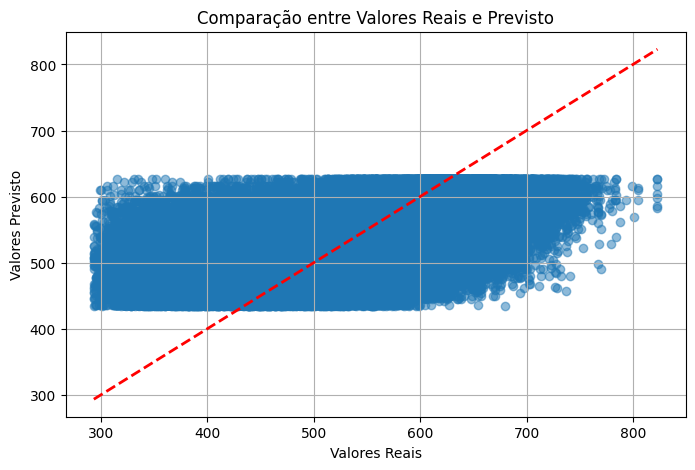

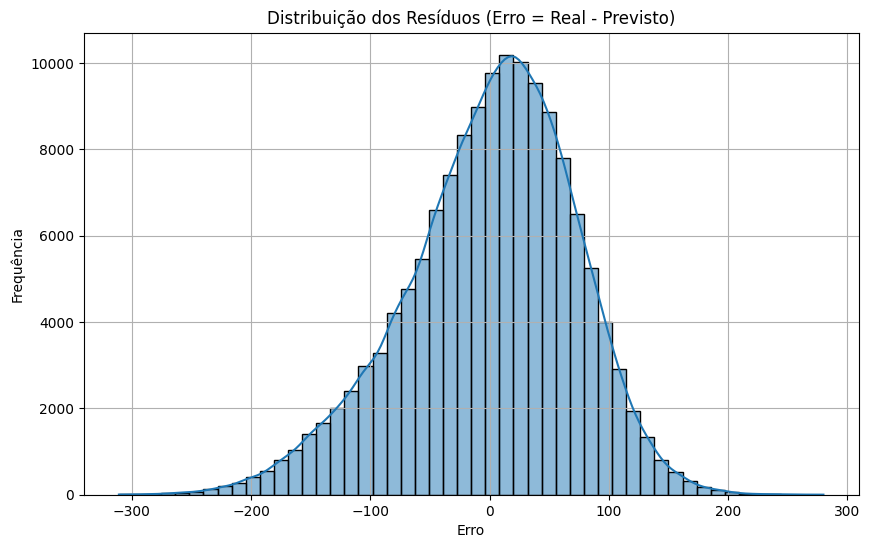

In [9]:
# Criar gráfico de comparação para cada variável alvo
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_arvore, alpha=0.5)
plt.title('Comparação entre Valores Reais e Previsto')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previsto')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid()
plt.show()

# Análise dos Resíduos
residuals = y_test - y_pred_arvore
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribuição dos Resíduos (Erro = Real - Previsto)")
plt.xlabel("Erro")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

### 2. Resultados do LGBM

In [10]:
# Obter dados
df_enem_lgbm = pd.read_pickle('Bases\\Finais\\enem_microdados_2023.pkl')

In [11]:
variaveis_alvo = ['NUM_NOTA_MT', 'NUM_NOTA_LC', 'NUM_NOTA_CN', 'NUM_NOTA_CH', 'NUM_NOTA_REDACAO']
grupo_previsao = ['NUM_NOTA_CH']

# separar em treino e teste
X = df_enem_lgbm.drop(columns=variaveis_alvo)
y = df_enem_lgbm[grupo_previsao]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ajuste de tipo para MLflow
# Converter colunas inteiras para float
X_train = X_train.astype({col: 'float' for col in X_train.select_dtypes('int').columns})
X_test = X_test.astype({col: 'float' for col in X_test.select_dtypes('int').columns})

categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()

# Criar Eval Set para validação cruzada (15% do conjunto de treino)
X_train_final, X_eval, y_train_final, y_eval = train_test_split(
    X_train,
    y_train,
    test_size=0.15,
    random_state=42
)

In [12]:
# Ajustar as dimensões dos arrays
y_test = y_test.squeeze()
y_train_final = y_train_final.squeeze()
y_eval = y_eval.squeeze()

In [13]:
# Carregar modelo treinado
with open('Modelos\\modelo_lgbm_bayes.pkl', 'rb') as file:
    modelo = joblib.load(file)

# Aplicar o modelo nos dados de teste
y_pred_lgbm = modelo.predict(X_test)

In [14]:
# Aplicar o modelo nos dados de teste
y_pred_lgbm = modelo.predict(X_test)

In [15]:
# Avaliação grupo teste
avaliar_modelo(y_test, y_pred_lgbm, "teste")

MAE (teste): 54.8517
RMSE (teste): 69.6036
R2 (teste): 0.3204


Comparativo entre resultados reais e resultados previstos

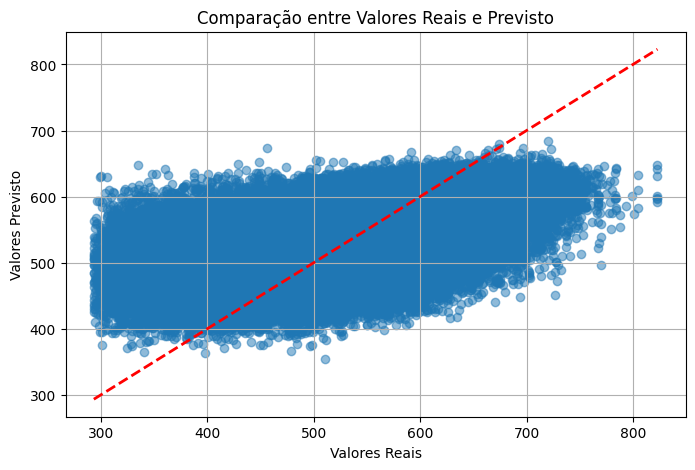

In [16]:
# Criar gráfico de comparação para cada variável alvo
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred_lgbm, alpha=0.5)
plt.title('Comparação entre Valores Reais e Previsto')
plt.xlabel('Valores Reais')
plt.ylabel('Valores Previsto')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.grid()
plt.show()

#### Resultados com primeiro processamento de dados incluindo Outliers em zero

![Execução com primeiro pré-processamento](Resultados/resultado_modelo_incluindo_zeros_lgbm_outliers.png)

- Tendencia geral é reconhecida pelo modelo
- Há uma distribuição atípica quando os valores reais são zero, os quais no modelo são previsto entre 350 e 650 aproximadamente
- O modelo não consegue prever zeros: no caso são outliers já previstos na exploração dos dados
- Faltam exemplos de zero para o modelo melhorar o treinamento e conseguir realizar esta previsão
- O modelo preve bem entre 350 e 650, mas tem dificuldade fora dessa margem: underfitting ou necessidade de melhora dos hiperparâmetros
- Há subestimação das notas alta e superstimação das notas baixas

#### Ideias:

- Trabalhar melhor com o zeros: 
    - estudar o significado deles, são casos reais de fato?
    - remover outliers
    - rever hiperparâmetros

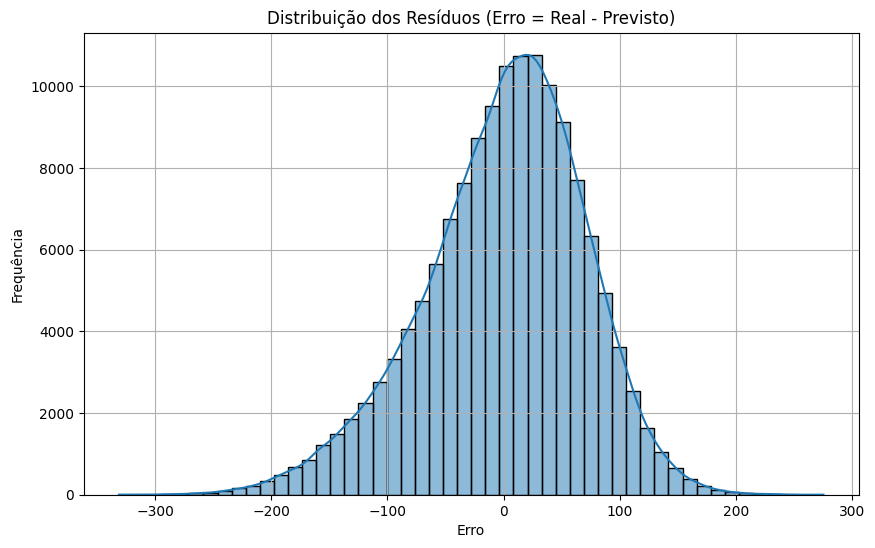

In [17]:
residuals = y_test - y_pred_lgbm
plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Distribuição dos Resíduos (Erro = Real - Previsto)")
plt.xlabel("Erro")
plt.ylabel("Frequência")
plt.grid(True)
plt.show()

#### Resultados com primeiro processamento de dados incluindo Outliers em Zero

![Execução com primeiro pré-processamento](Resultados/resultado_modelo_incluindo_zeros_residuos.png)

#### Análise dos resíduos

- distribuição se mostra normal centrada em zero
- os erros estão em geral em torno de zero
- modelo está com baixo viés não superestimando ou subestimando as notas

#### Notas Zero

- Verificar se são reais ou não
    - Se não forem reais (ausencia ou erro) deve-se remover
    - Se forem reais é interessante criar um modelo para prever zeros ou uma coluna de prova realiza ou não

In [18]:
df_resultado = pd.DataFrame({'real': y_test, 'previsto': y_pred_lgbm})
df_resultado['faixa'] = pd.cut(df_resultado['real'], bins=[0, 300, 500, 700, 1000])

# Corrigir o aviso de depreciação com include_groups=False
resultados = df_resultado.groupby('faixa', observed=False).apply(
    lambda x: mean_absolute_error(x['real'], x['previsto']), include_groups=False
)
print(resultados)

faixa
(0, 300]       194.713799
(300, 500]      68.673194
(500, 700]      46.183020
(700, 1000]    126.348951
dtype: float64


In [19]:
# Criar faixas e calcular porcentagem e MAE em um único DataFrame
df_porcentagem = (
    df_resultado
    .assign(Faixa=pd.cut(df_resultado['real'], bins=[0, 300, 500, 700, 1000]))
    .groupby('Faixa', observed=False)
    .agg(
        Amostra=('real', lambda x: round(len(x) / len(df_resultado) * 100, 1)),
        MAE=('real', lambda x: mean_absolute_error(x, df_resultado.loc[x.index, 'previsto']))
    )
    .reset_index()
)

print(df_porcentagem)

         Faixa  Amostra         MAE
0     (0, 300]      0.1  194.713799
1   (300, 500]     34.5   68.673194
2   (500, 700]     64.4   46.183020
3  (700, 1000]      1.0  126.348951


#### Resultados com primeiro processamento de dados incluindo Outliers

#### MAE por faixa da base pré-processada inicial

    faixa
    (0, 300]       194.537290
    (300, 500]      68.541698
    (500, 700]      46.976290
    (700, 1000]    127.130647

- Maior erro está abaixo de 300
- Depois acima de 700 -> Pode haver uma baixa quantidade de amostrar para valores acima de 700

### Balancear dados

- SMOTE ou subamostragem para equilibrar extremidades
- ponderar erros por faixa
- criar modelos diferentes para faixas diferentes